In [ ]:
# 3rd party imports
import os
import time
import requests

import pandas as pd
import matplotlib.pyplot as plt


from datetime import datetime

In [55]:
from efficientnet_pytorch import EfficientNet as effnet

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from tqdm import tqdm
import torch
import numpy as np
import cv2
import json
import os

# Settings

In [2]:
INPUT_PATH = '../data/raw/'
OUT_PATH = '../data/processed/'

imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

In [3]:
images = []
poses = []

for path, subdirs, files in os.walk(INPUT_PATH):
    for name in files:
        if name.find('.png')!=-1:
            images.append(path+'/'+name)
        if name.find('pose')!=-1:
            poses.append(path+'/'+name)

# Check image embeddings

In [95]:
#restore pre-trained model
effnet = effnet.from_pretrained('efficientnet-b2').to('cuda:0')

#apply embeddings
embedddings = []

for image in tqdm(images):
    
    #read the image, apply normalization
    image = cv2.imread(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image.astype(np.float32)/ 255
    image = (image-imagenet_mean)/imagenet_std
    image = np.transpose(image,(2,0,1))
    
 
    
    #get embbedings
    emb = effnet.extract_features(torch.Tensor(image).unsqueeze(0).to('cuda:0'))[0,:]
    emb = emb.sum(dim=1).sum(dim=1).cpu().detach().numpy()
    
    embedddings.append(emb)
    
    
    
#apply pca/tSNE
embedddings = np.array(embedddings)
embedddings_compressed = TSNE(n_components=2, learning_rate='auto', init='random',random_state=42).fit_transform(embedddings)



#plot embeddings, examples from all clustersembeddings

  0%|                                          | 2/6860 [00:00<06:52, 16.61it/s]

Loaded pretrained weights for efficientnet-b2


100%|███████████████████████████████████████| 6860/6860 [08:44<00:00, 13.07it/s]


In [76]:
#embedddings_compressed = PCA(n_components=2,random_state=42).fit_transform(embedddings)
embedddings = np.array(embedddings)
embedddings_compressed = TSNE(n_components=2, learning_rate='auto', init='random',random_state=42).fit_transform(embedddings)

In [92]:
#apply clustering
#clusters = KMeans(n_clusters=7, random_state=1).fit_predict(embedddings_compressed)
clusters = GaussianMixture(n_components=11, random_state=1,max_iter=1000,n_init=10,init_params='kmeans').fit_predict(embedddings_compressed)

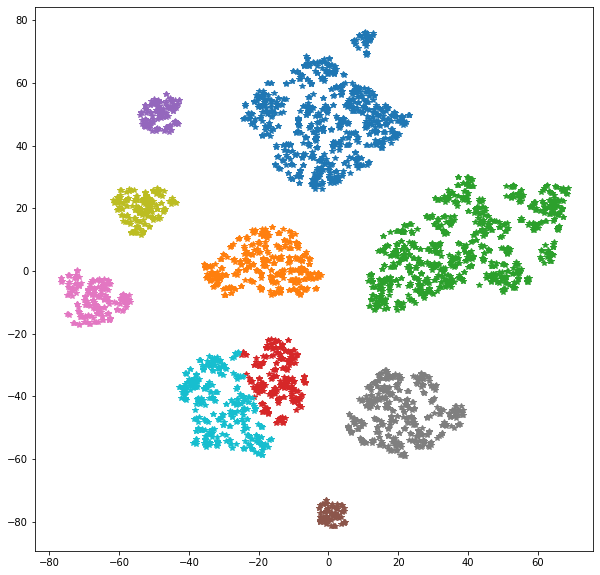

In [93]:
fig = plt.figure(figsize=(10,10))

for i in range(10):
    temp = embedddings_compressed[clusters==i,:]
    plt.plot(temp[:,0],temp[:,1],'*')

In [94]:
CLUSTER = 0
INDEX = 0

images_array = np.array(images)

images_array = images_array[clusters==INDEX]


image = cv2.imread(images_array[index])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 6860 but corresponding boolean dimension is 3769

# Get JET records

In [ ]:
index = 0
for path in INPUT_PATHS:
    
    files = [i for i in os.listdir(path) if i.find('.csv')!=-1 and i.find('categories')==-1]
    
    for file in files:
        if index == 0:
            df = pd.read_csv(path+file)
            df['labeler'] = path.split('/')[-2]
            index+=1
        else:
            temp = pd.read_csv(path+file)
            temp['labeler'] = path.split('/')[-2]
            df = df.append(temp,ignore_index=True)


df['diff'] = df['Label_End'].values - df['Label_Start'].values
df_error = df[df['diff'] <= 0]
df = df[df['diff'] > 0]

df = df.drop_duplicates()

temp = df['Link'].str.split("patient=", n = 1, expand = True)
temp = temp[1]

temp = temp.str.split("&starttime=", n = 1, expand = True)
df['patient'] = temp[0]

classes = df['Label_Name'].unique()
label_name = df['Label_Name'].values

for cl in classes:
    if cl == 'NRS':
        continue
    elif cl.find('JET')!=-1:
    #elif cl == 'JET':
        label_name[label_name == cl] = 'JET'
    else:
        label_name[label_name == cl] = 'Other'

df['Label_Name'] = label_name

print(f'Shape of the dataframe: {df.shape}')
df.head(5)

In [ ]:
print(f"JET segments: {df[df['Label_Name']=='JET'].shape[0]}, Class balance: {df[df['Label_Name']=='JET'].shape[0]/df.shape[0]}")
print(f"NRS segments: {df[df['Label_Name']=='NRS'].shape[0]}, Class balance: {df[df['Label_Name']=='NRS'].shape[0]/df.shape[0]}")
print(f"Other segments: {df[df['Label_Name']=='Other'].shape[0]}, Class balance: {df[df['Label_Name']=='Other'].shape[0]/df.shape[0]}")

# Download the data

In [ ]:
patient_links  = df['Link'].unique()

for patient_link in tqdm(patient_links):
    
    
    ecg_record_full = get_ecg_waveform(patient_link)
    
    ecg_record_full = ecg_record_full[1]
    
    
    
    patient_df = df[df['Link'] == patient_link]
    patient_name = patient_link.split('patient=')[1]
    patient_name = patient_name.split('&starttime')[0]
    

    for patient in patients:
        if patient['mrn'] == int(patient_name):
            dob = patient['dob']
    
    start_time = patient_link.split('&starttime=')[1]
    start_time = start_time.split('&endtime')[0]
    start_time = int(start_time)
    
    
    age = (start_time - dob)/(60*60*24*365)

    
    
    
    labels_mask = np.zeros(ecg_record_full.shape)-1
    
    for label in range(patient_df.shape[0]):
        name = patient_df['Label_Name'].values[label]
        name = name.lower()
        if name.find('other')!=-1:
            name = 0
        elif name.find('nrs')!=-1:
            name = 0
        elif name.find('jet')!=-1:
            name = 1
        else:
            print('New label: ',name)
        labels_mask[patient_df['Label_Start'].values[label]:patient_df['Label_End'].values[label]] = name
    
    labels_mask = labels_mask.astype(np.int32)
    
 
    if ecg_record_full.shape[0]//SIG_LENGTH == 0:
        print('print')
        break
    
    for segment in range(ecg_record_full.shape[0]//SIG_LENGTH):
        
        
        ecg_segment = ecg_record_full[segment*SIG_LENGTH:(segment+1)*SIG_LENGTH]
        labels_segment = np.unique(labels_mask[segment*SIG_LENGTH:(segment+1)*SIG_LENGTH]).tolist()
        
        ann = {
                'start':[int(segment*SIG_LENGTH)],
                'end': [int((segment+1)*SIG_LENGTH)],
                'age': age
            }
        
        labels_oh = [0,0]
        
        if 1 in labels_segment:
            labels_oh[1] = 1
        
#         if 2 in labels_segment:
#             labels_oh[2] = 1
            
        if labels_oh[1] == 0:
            labels_oh[0] = 1
        
        ann['label'] = labels_oh
        
        os.makedirs(OUT_PATH+patient_name,exist_ok=True)
            
        #save data
        np.save(OUT_PATH+patient_name+f'/{segment}.npy',ecg_segment)
        with open(OUT_PATH+patient_name+f'/{segment}.json', 'w') as outfile:
                json.dump(ann, outfile)
        
    
    
